In [1]:
from datetime import datetime, timedelta, time
import pandas as pd
import numpy as np
import datajoint as dj
from pipeline import pipeline_tools, lab, experiment, behavioranal
dj.conn()
import matplotlib.pyplot as plt
import decimal
%matplotlib inline
from plot.plot_behavior import *

Connecting rozmar@mesoscale-activity.datajoint.io:3306


# Weight change and water consumption
All mice returned to baseline weight despite they drink little water..

/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:62: RuntimeWarning: invalid value encountered in long_scalars
  early_lick_rate = (df_earlylick == 'early').values.sum()/trialnum


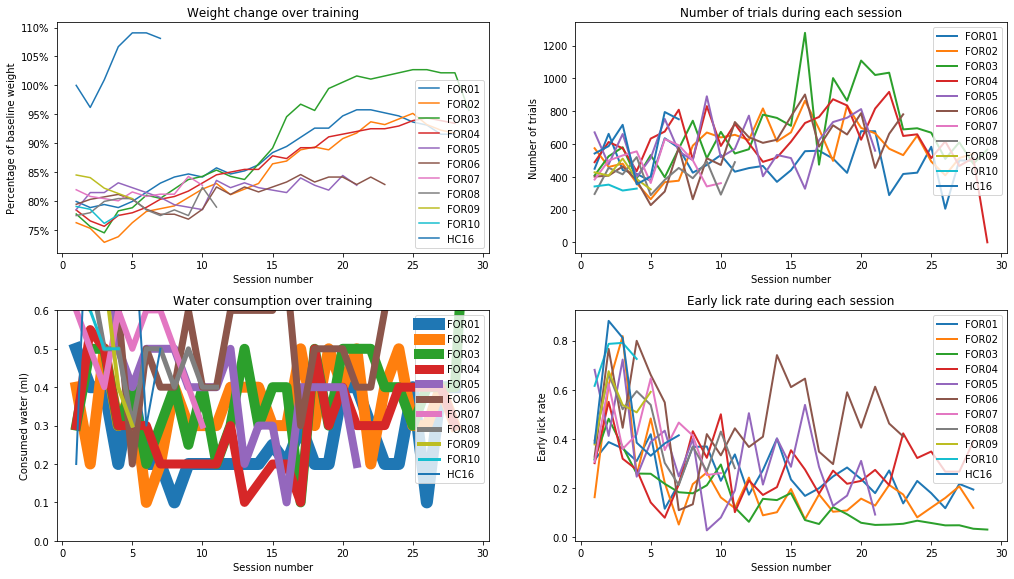

In [2]:
plot_weight_water_early_lick()

# Autowater
Autowater (water cue after multiple miss trials) was not used from week 2, except for FOR01 who had a huge bias on a few days
(autowater was turned on if the animal igored 10 trials in a row at the end of the session, these are the small bumps from the second week)

Text(0.5, 1.0, 'Autowater')

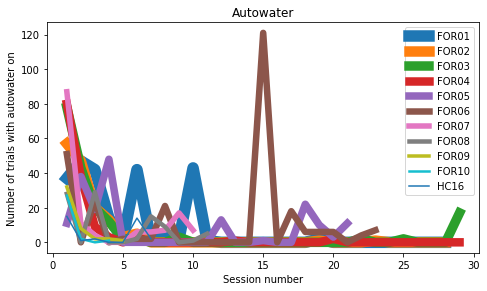

In [3]:
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
fig=plt.figure()
ax_autowater=fig.add_axes([0,0,1,.8])
for i,wr_name in enumerate(subject_names):
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {'subject_id':subject_id}
    sessionnum = len(experiment.Session()&key)
    autowater_nums = list()
    
    for session in range(1,sessionnum+1):  
        key = {'session':session,'subject_id':subject_id}    
        autowater_num = len((experiment.TrialNote()&key))
        autowater_nums.append(autowater_num)
    ax_autowater.plot(range(1,len(autowater_nums)+1),autowater_nums,linewidth=len(subject_names)+.5-i)    
ax_autowater.legend(subject_names)
ax_autowater.set_xlabel('Session number')
ax_autowater.set_ylabel('Number of trials with autowater on')
ax_autowater.set_title('Autowater')   

# reaction times for the last session:
The first two mice (Bari-Cohen training) are trying to guess the GO cue

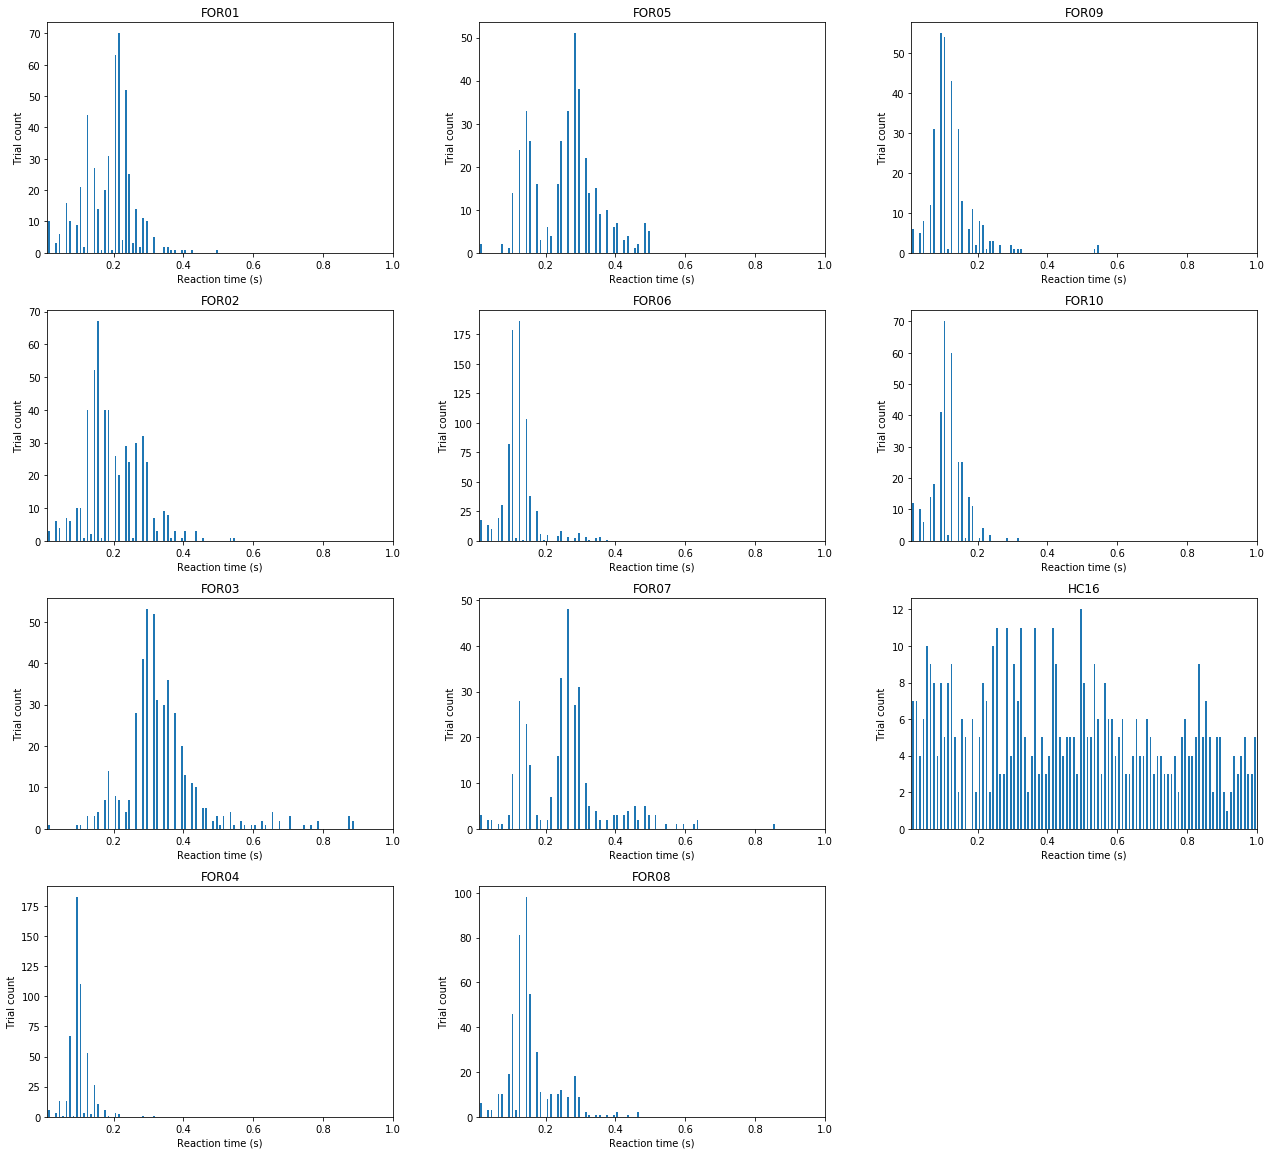

In [4]:
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()

fig=plt.figure()
ax_RT = list()
for i,subject in enumerate(subject_names):
    key = dict()
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+subject+'"').fetch('subject_id')[0]
    key['subject_id'] = subject_id
    session = (experiment.Session()&key).fetch('session').max()
    key['session'] = session
    df_reactiontime = pd.DataFrame((behavioranal.SessionReactionTimeHistogram() & key)*(lab.WaterRestriction &key))
    while len(df_reactiontime)<1:
        session -= 1
        key['session'] = session
        df_reactiontime = pd.DataFrame((behavioranal.SessionReactionTimeHistogram() & key)*(lab.WaterRestriction &key))
    ax_RT.append(fig.add_axes([np.floor((i/4)%4),-1*(i%4),.8,.8]))
    idx = df_reactiontime['water_restriction_number'] == subject
    bins = df_reactiontime['reaction_time_bins'][idx].values[0][1:]
    edges = [np.min(bins),np.max(bins)]
    bins = bins - (bins[1] -bins[0])/2
    vals = df_reactiontime['reaction_time_values_all_trials'][idx].values.tolist()[0]
    ax_RT[-1].bar(bins,vals, (bins[1] -bins[0])/2)
    ax_RT[-1].set_xlim(edges)
    ax_RT[-1].set_title(subject)
    ax_RT[-1].set_xlabel('Reaction time (s)')
    ax_RT[-1].set_ylabel('Trial count')

# Number of licks on miss trials after the first lick in each session:
(if the retraction is fast enough, it should be 0)  
Sessions 1-7 : softcode and slow motor movement  
Sessions 7-11 : softcode and fast motor movement  
Sessions 12-19: same as above but two bpods controlled from the same PC  
Sessions 19- : zaber motor is directly triggered  

Text(0.5, 1.0, 'Lick count on miss trials')

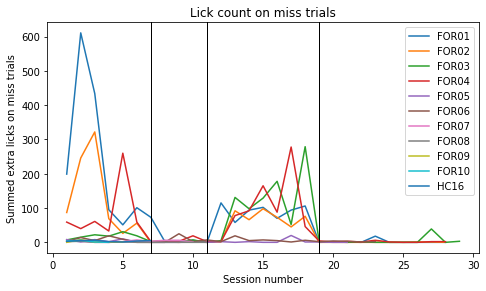

In [5]:
#%% licks on miss trials

df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()


df_misslicknums = pd.DataFrame()
fig=plt.figure()
ax_misslick = fig.add_axes([0,0,1,.8])
for wr_name in subject_names:
    #%
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {'subject_id':subject_id}   
    df_lickrhythm = pd.DataFrame((behavioranal.SessionLickRhythmHistogram() & key)*(lab.WaterRestriction &key))
    #%
    
    sessionnum = list()
    licknum = list()
    if len(df_lickrhythm)>0:
        for i,session in enumerate(df_lickrhythm['session']):
            idx = df_lickrhythm['session'] == session
            bins = df_lickrhythm['lick_rhythm_bins'][idx].values[0][1:]
            edges = [np.min(bins),np.max(bins)]
            bins = bins - (bins[1] -bins[0])/2 
            vals = df_lickrhythm['lick_rhythm_values_miss_trials'][idx].values.tolist()[0]
            sessionnum.append(session)
            licknum.append(vals[bins>.015].sum())       
        ax_misslick.plot(sessionnum,licknum)
protocolchanges = [7,11,19]
ylimedges = ax_misslick.get_ylim()
ax_misslick.plot(protocolchanges,np.ones(len(protocolchanges))*np.mean(ylimedges),'k|',markersize = np.diff(ylimedges))
ax_misslick.set_ylabel('Summed extra licks on miss trials')
ax_misslick.set_xlabel('Session number')
ax_misslick.legend(subject_names)
ax_misslick.set_title('Lick count on miss trials')


# Logistic regression for weeks 2-4

[0.83798066 0.35906449 0.27678717 0.11402664 0.00706481 0.05823909
 0.01322758 0.08025401 0.02533904 0.        ]


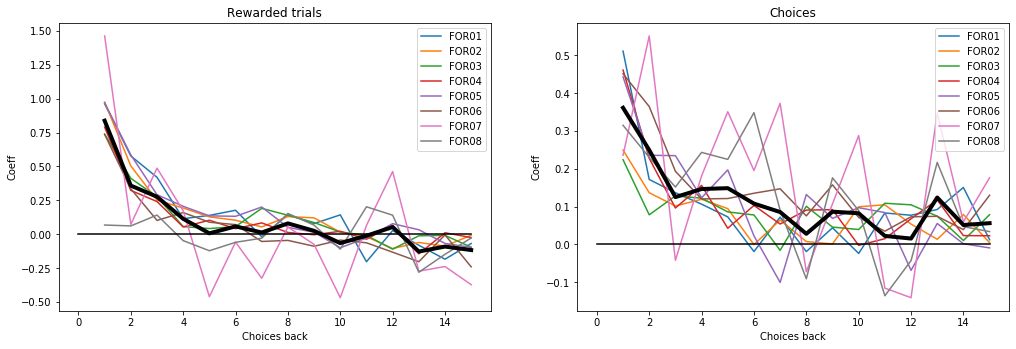

In [6]:
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
df_coeff = pd.DataFrame(behavioranal.SubjectFittedChoiceCoefficients())
fig=plt.figure()
ax1=fig.add_axes([0,0,1,1])  
ax2=fig.add_axes([1.2,0,1,1])  
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    idx = df_coeff['subject_id']==subject_id
    if sum(idx) == 1:
        ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'][idx].values[0])
        ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_choices_subject'][idx].values[0])

ax1.set_xlabel('Choices back')
ax1.set_ylabel('Coeff')
ax1.set_title('Rewarded trials')
ax1.legend(subject_names)
ax2.set_xlabel('Choices back')
ax2.set_ylabel('Coeff')
ax2.set_title('Choices')
ax2.legend(subject_names)
ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'].mean(),'k-',linewidth = 4)
ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_choices_subject'].mean(),'k-',linewidth = 4)
ax1.plot([0,15],[0,0],'k-')
ax2.plot([0,15],[0,0],'k-')
template = df_coeff['coefficients_rewards_subject'].mean()[:10]
template[template<0]=0
print(template)

# Display last session:

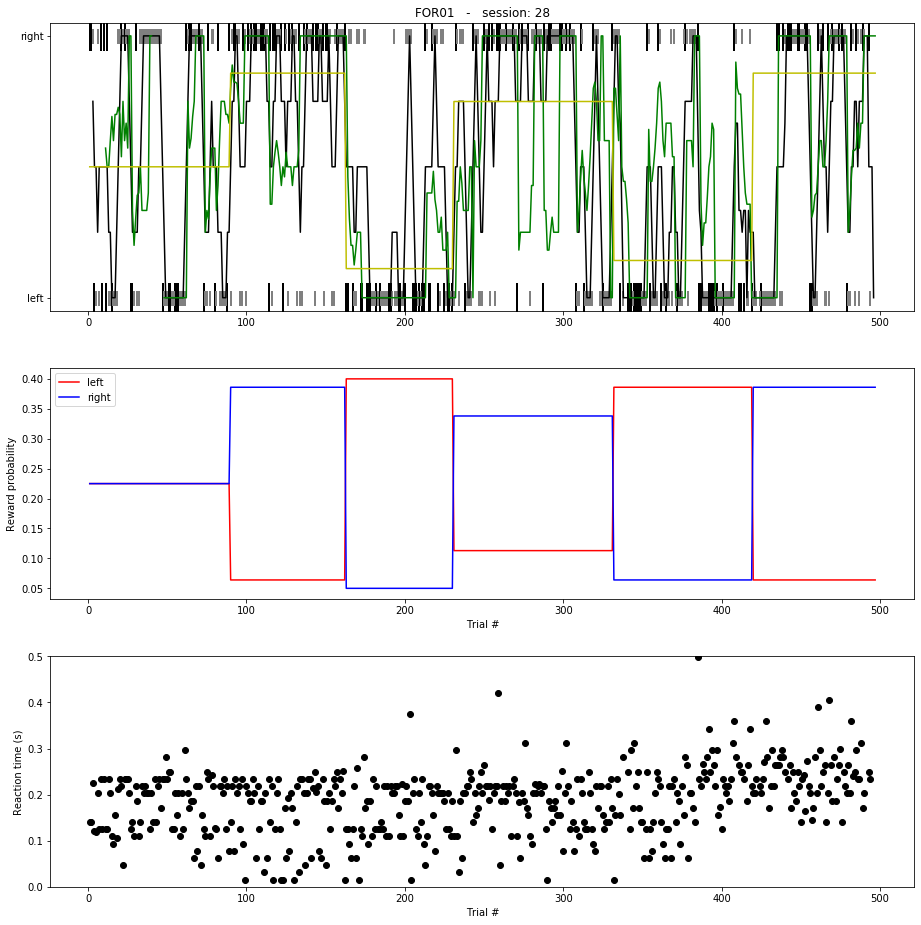

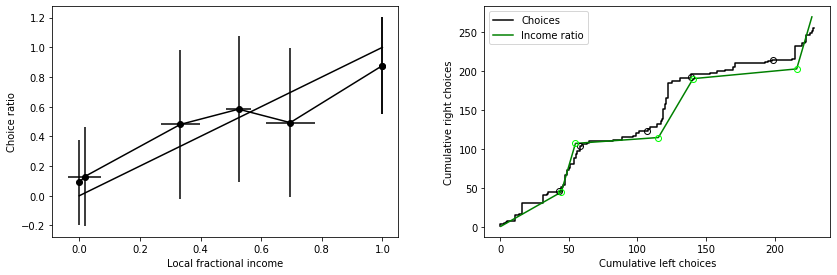

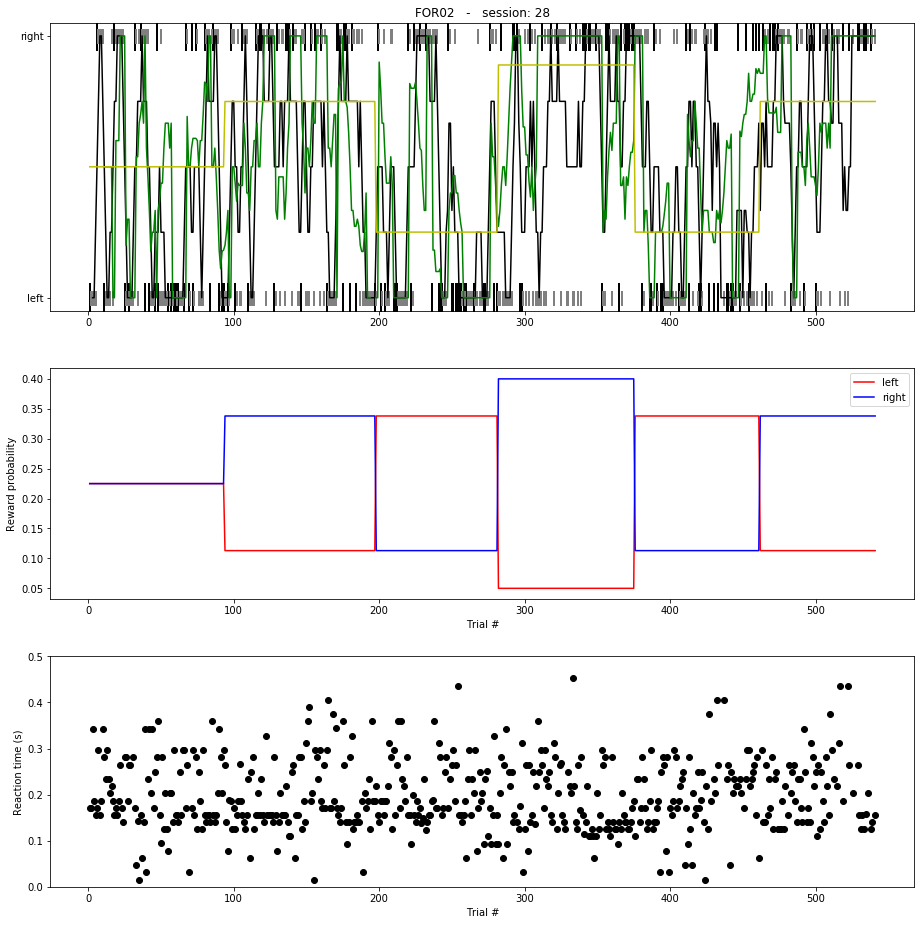

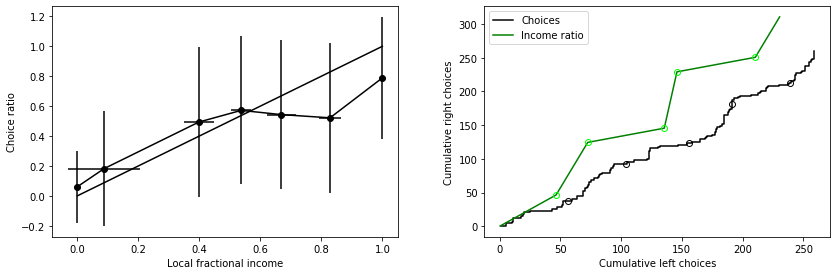

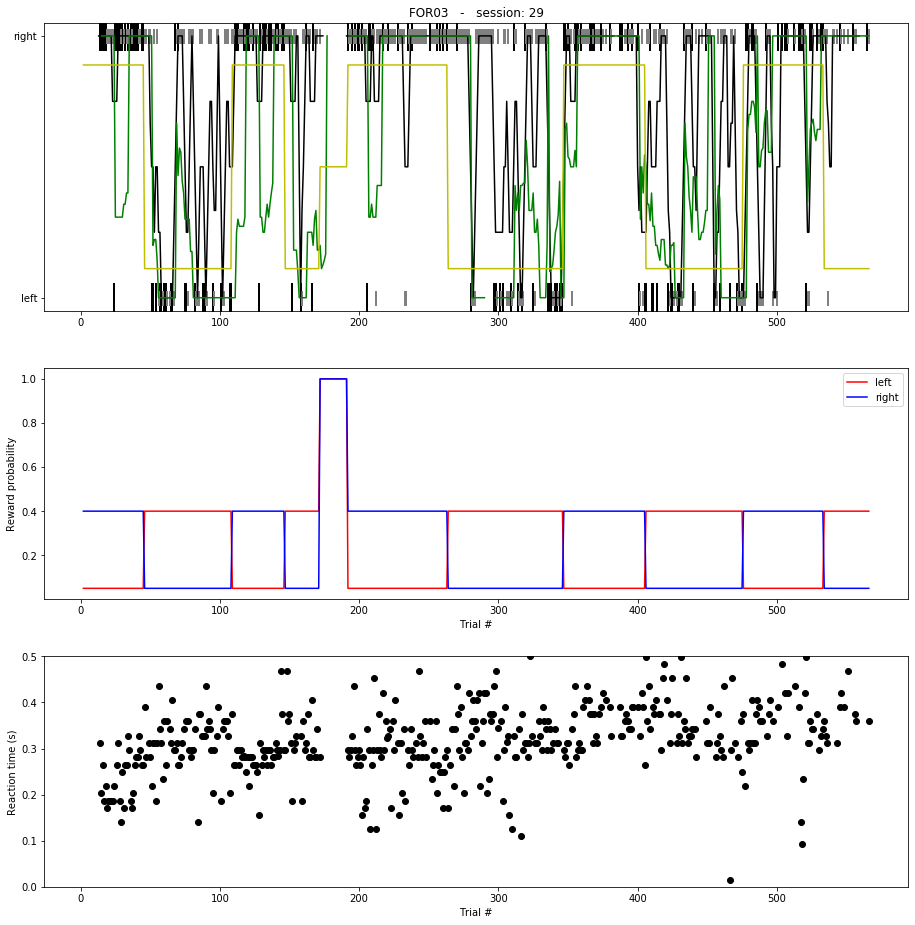

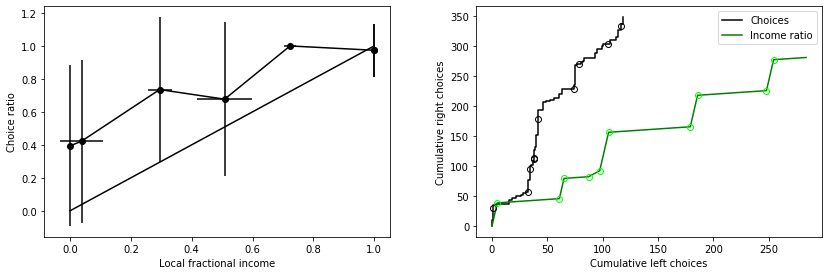

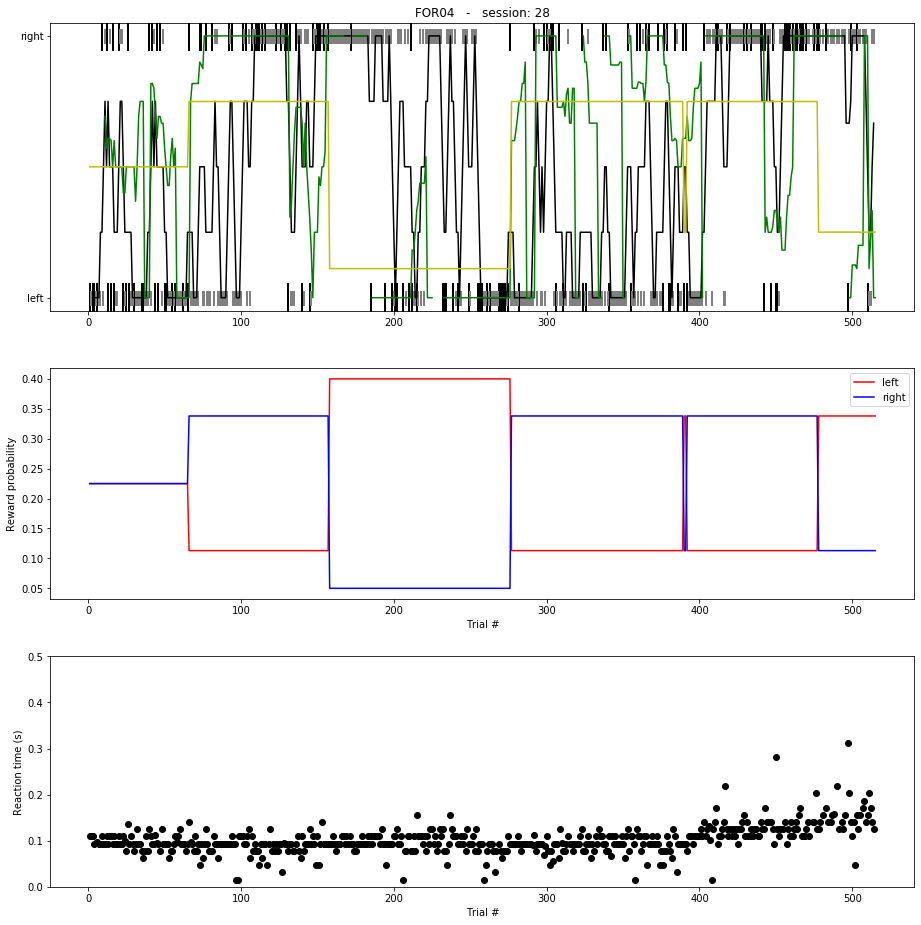

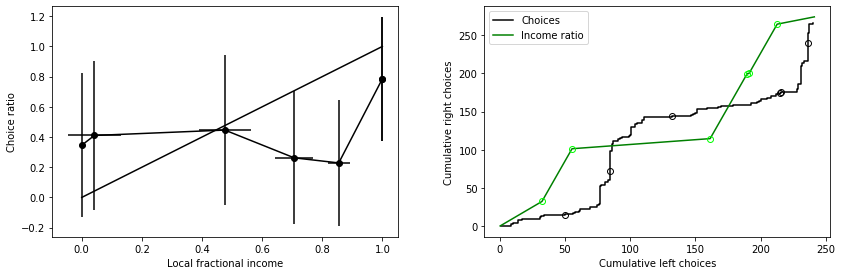

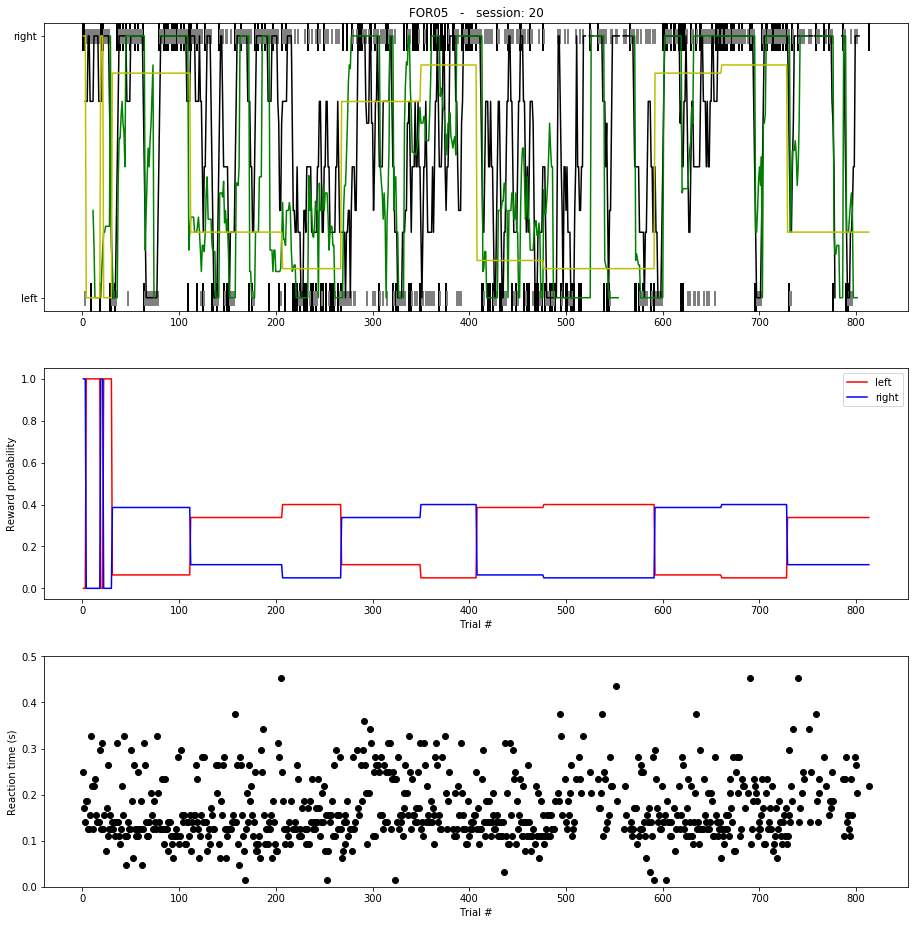

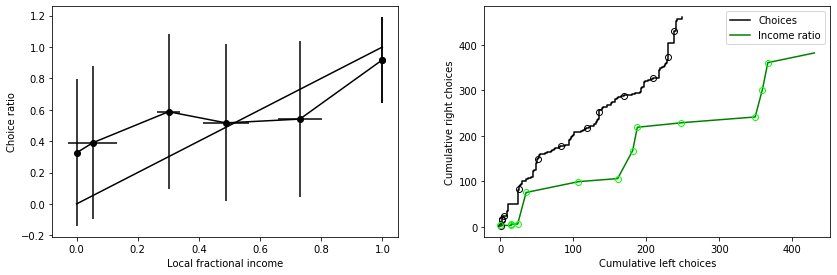

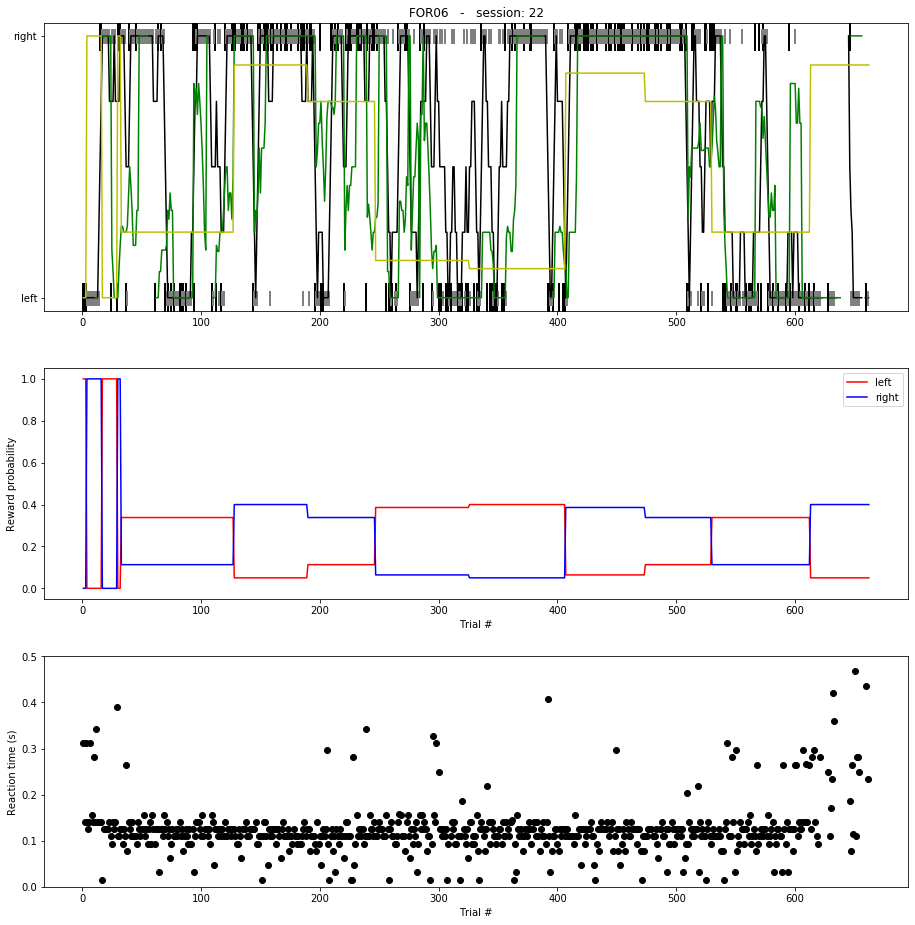

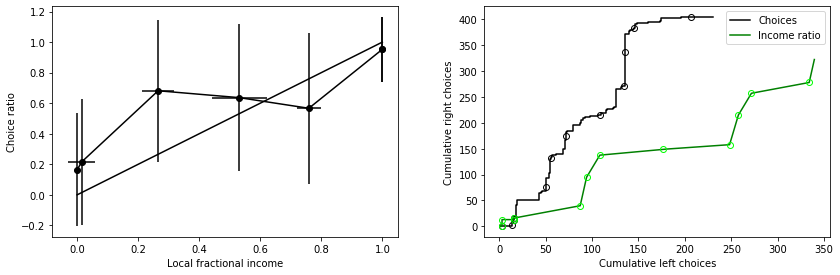

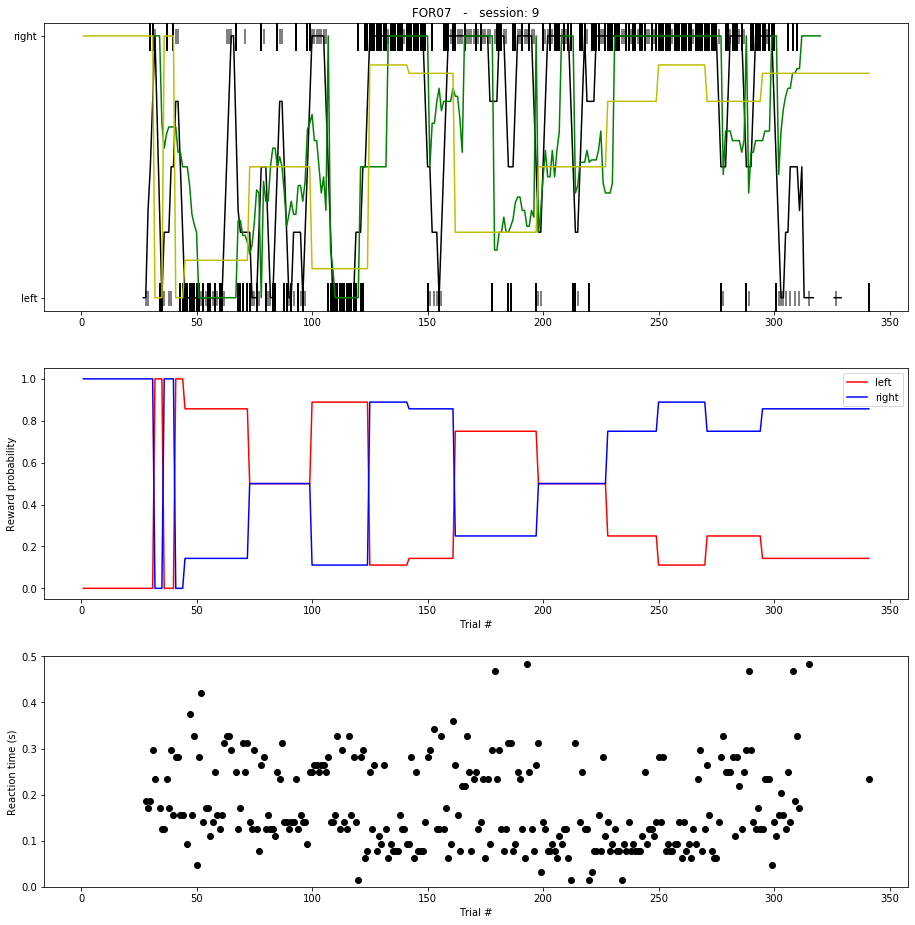

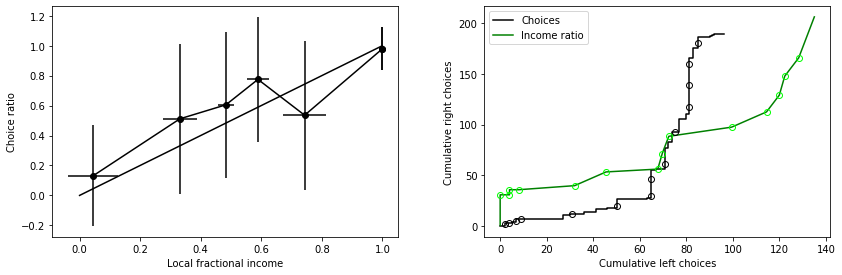

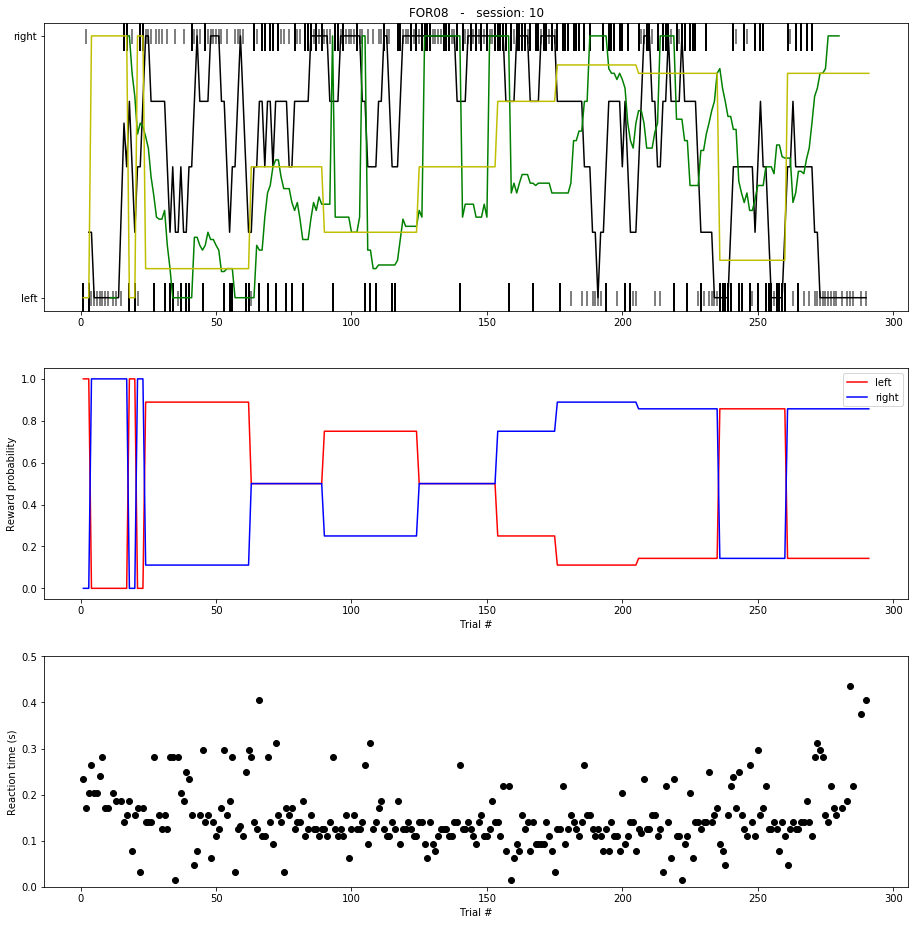

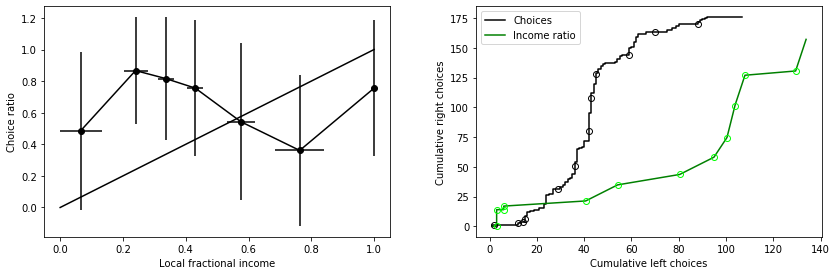

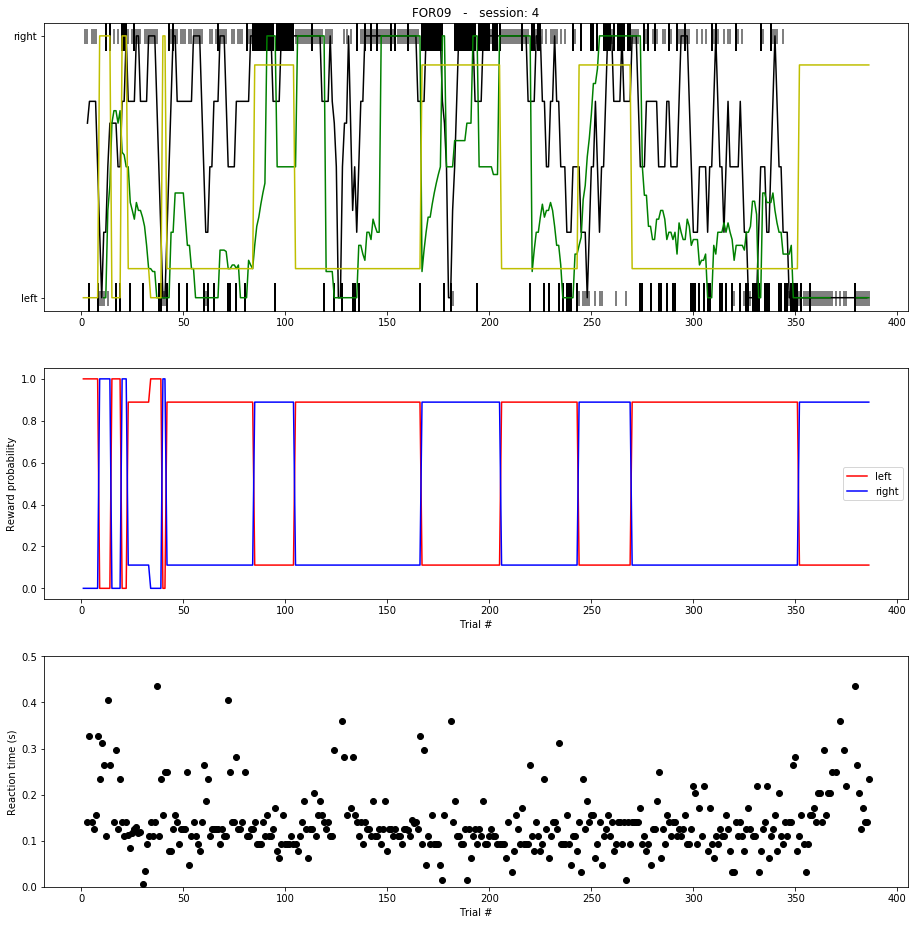

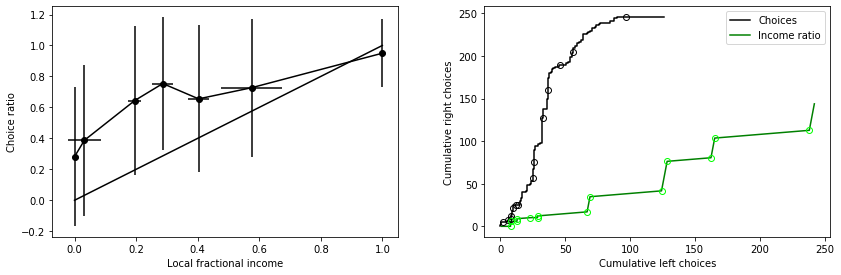

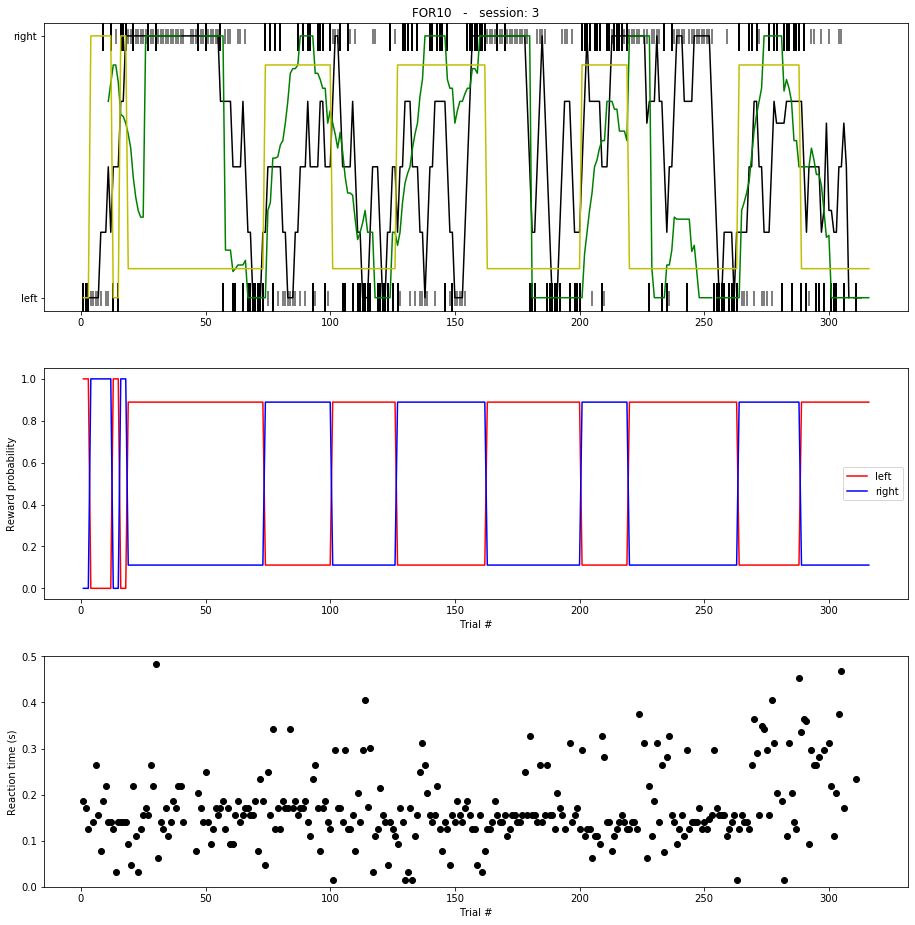

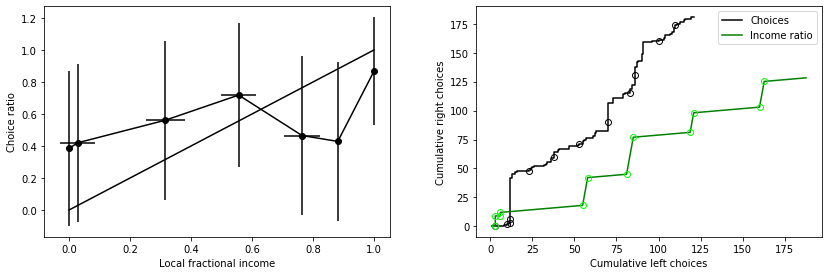

In [10]:
template = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
plot_one_session(wr_name = 'FOR01',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR02',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR03',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR04',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR05',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR06',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR07',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR08',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR09',session = 'last',local_filter = template)
plot_one_session(wr_name = 'FOR10',session = 'last',local_filter = template)

Behavior on block switches for all animals

453478
453475
453477
453476


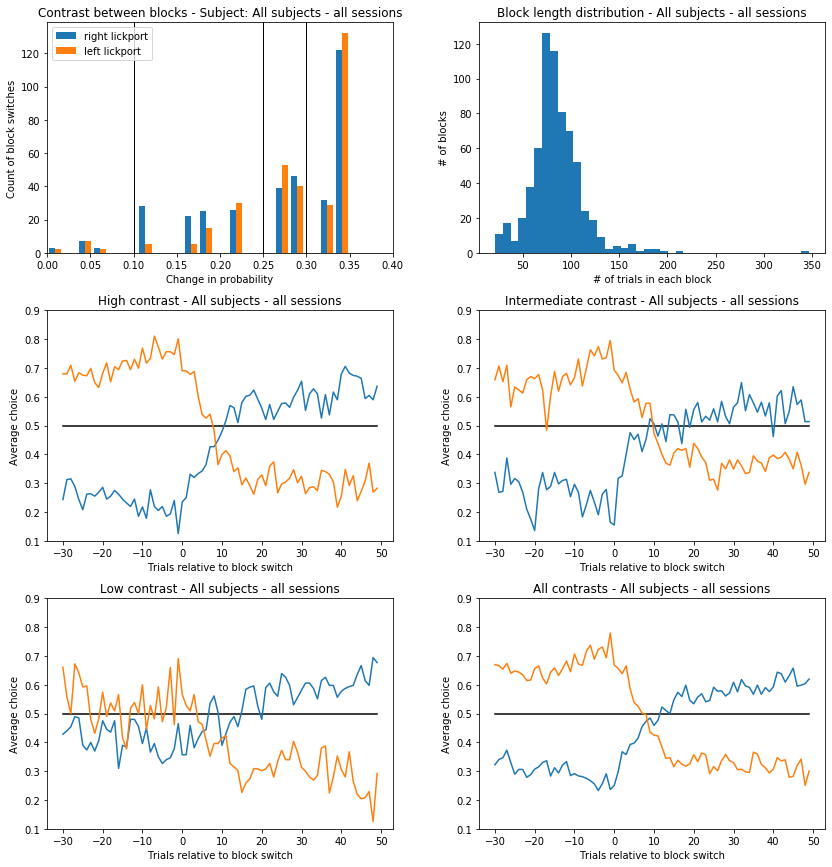

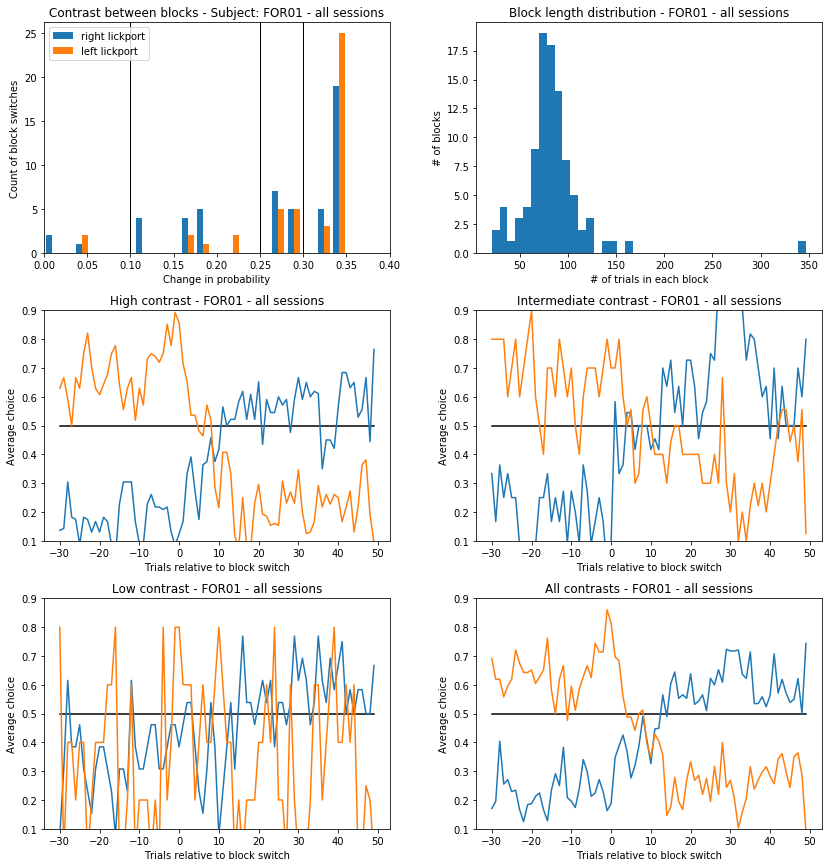

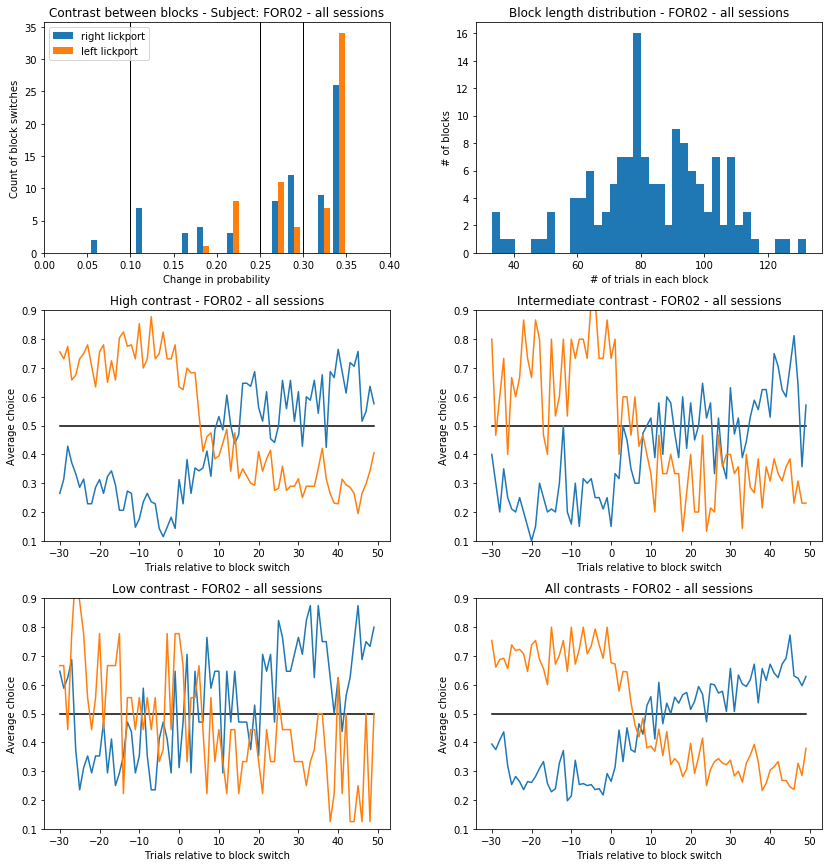

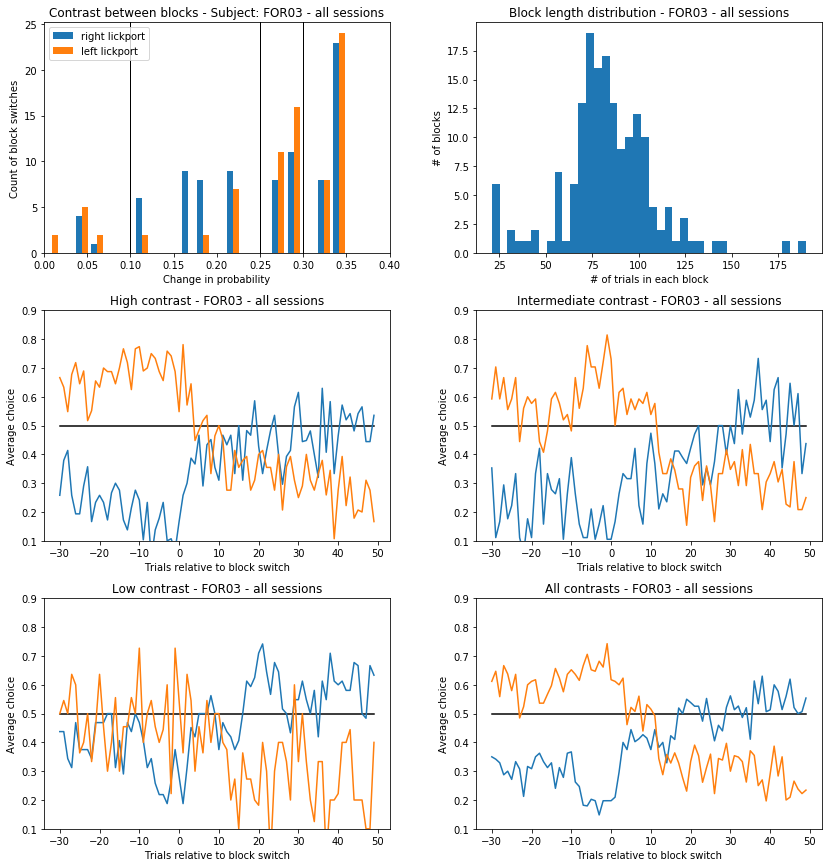

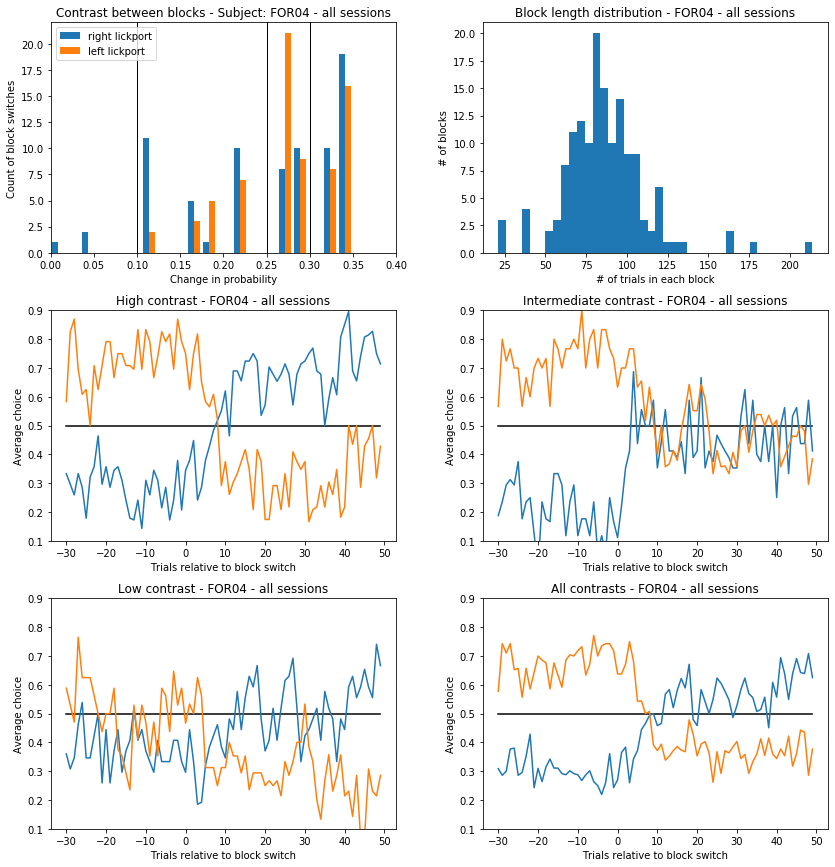

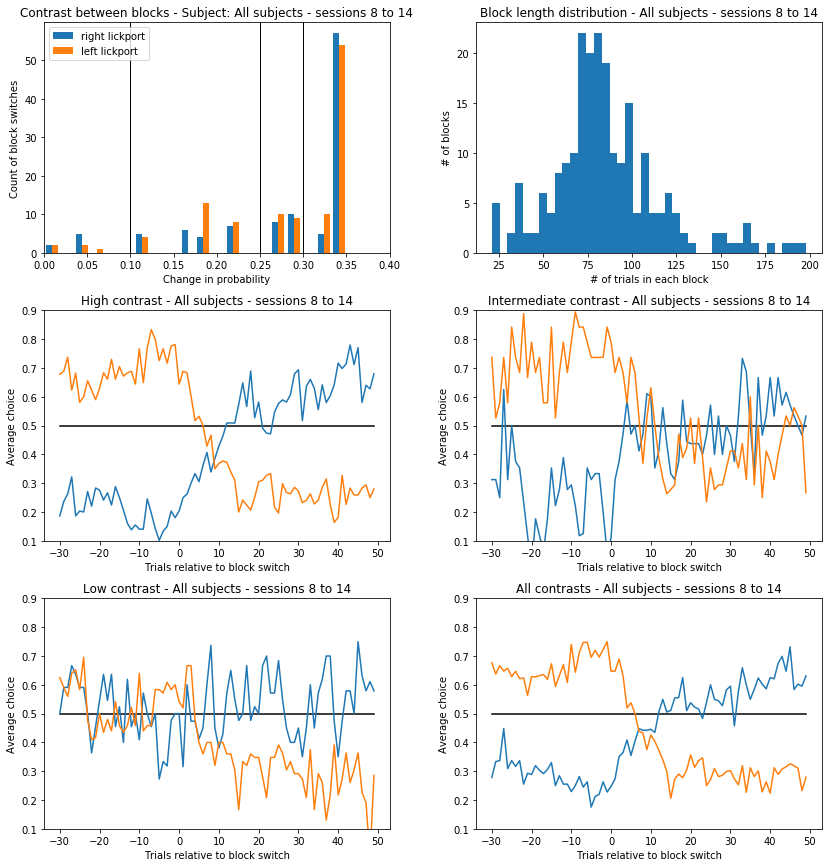

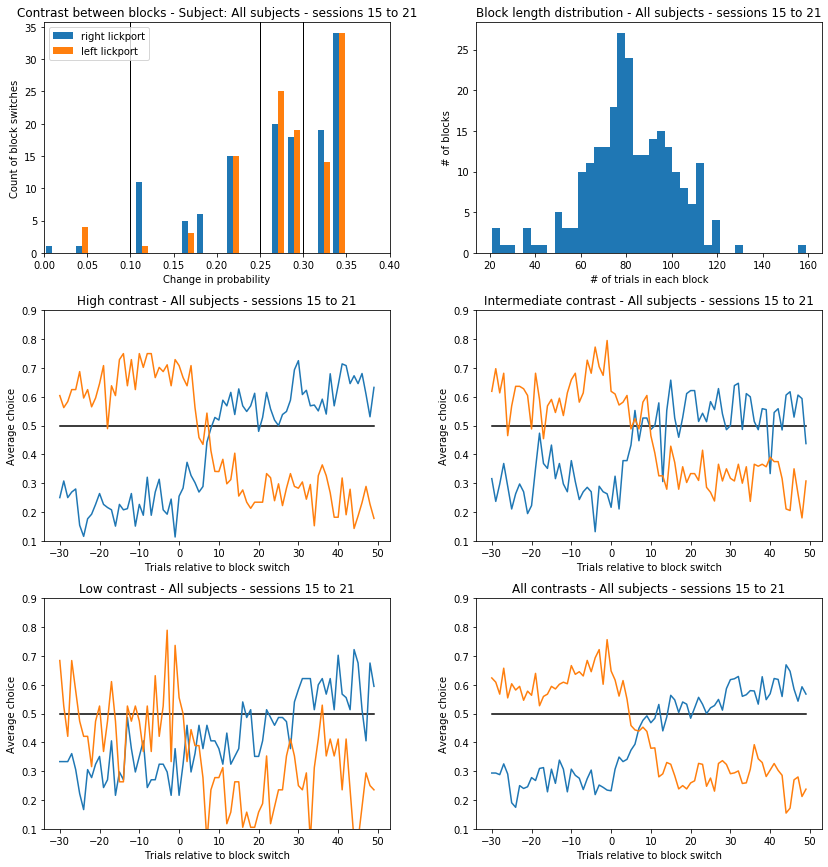

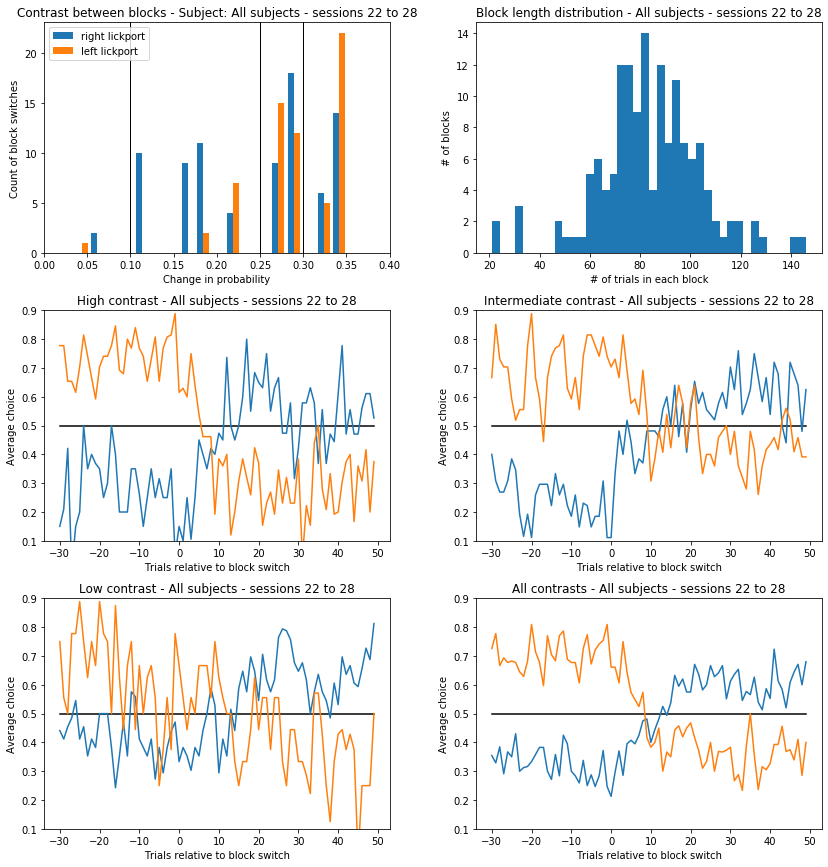

In [13]:
plot_block_switches()
plot_block_switches('FOR01')
plot_block_switches('FOR02')
plot_block_switches('FOR03')
plot_block_switches('FOR04')
plot_block_switches(sessions = [8, 14])
plot_block_switches(sessions = [15, 21])
plot_block_switches(sessions = [22, 28])

457494


/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:138: RuntimeWarning: Mean of empty slice
  ax3.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:140: RuntimeWarning: Mean of empty slice
  ax3.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:149: RuntimeWarning: Mean of empty slice
  ax4.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:151: RuntimeWarning: Mean of empty slice
  ax4.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:160: RuntimeWarning: Mean of empty slice
  ax5.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:162: RuntimeWarning: Mean of empty slice
  ax5.plot(np.arange(-30,50),np.nanmean(b

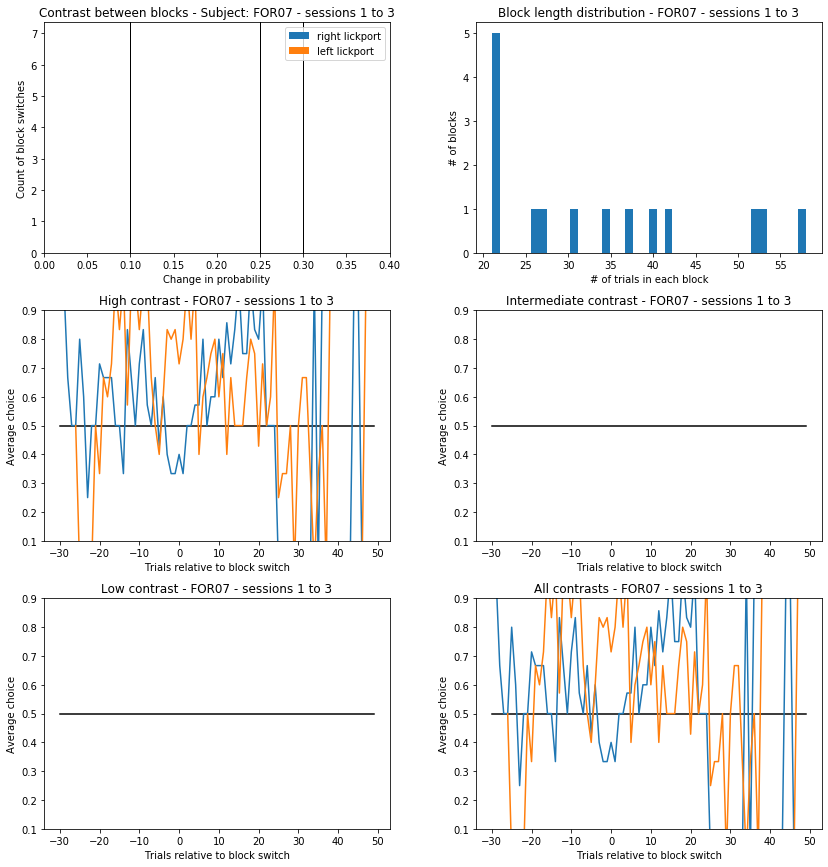

In [18]:
plot_block_switches('FOR07',[1,3])

# Logistic regression session by session

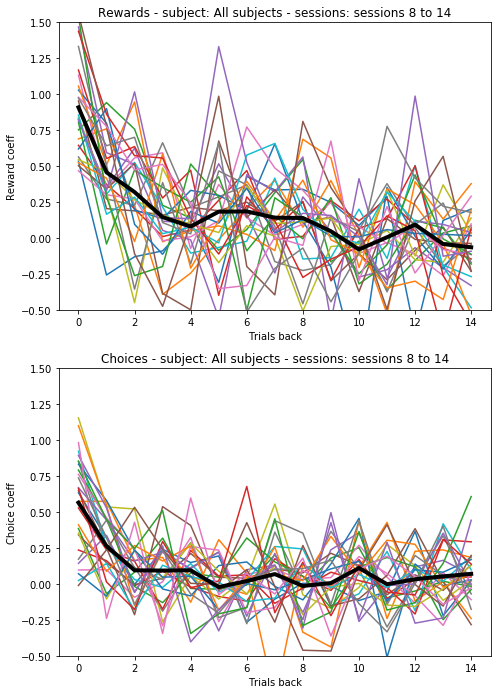

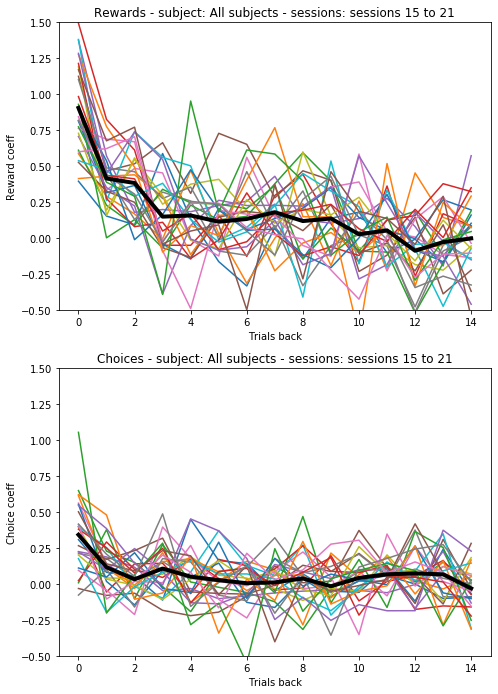

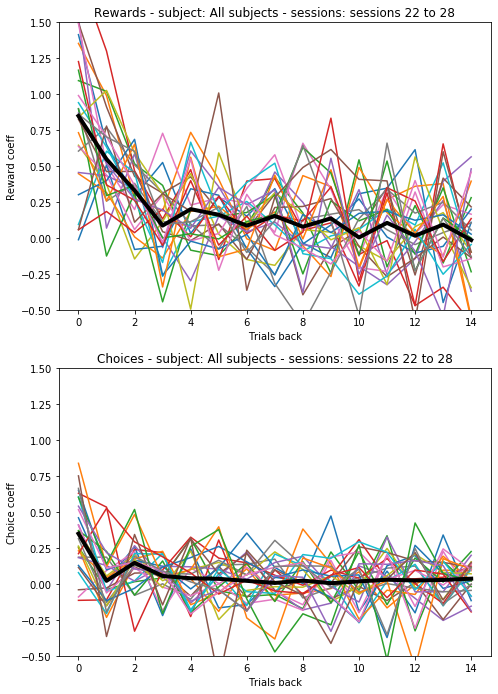

In [10]:
plotregressionaverage(sessions = [8,14])
plotregressionaverage(sessions = [15,21])
plotregressionaverage(sessions = [22,28])


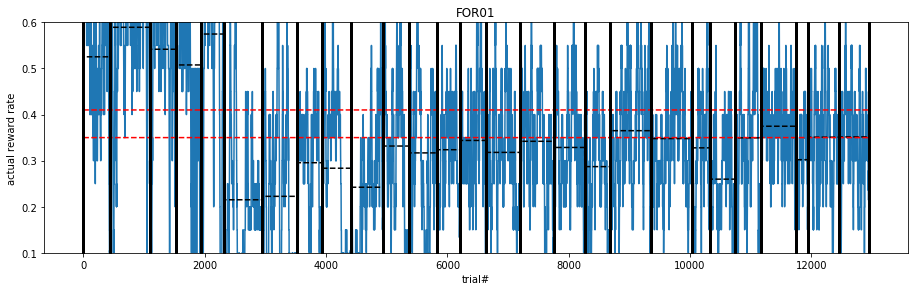

In [5]:

plot_reward_rate('FOR01')


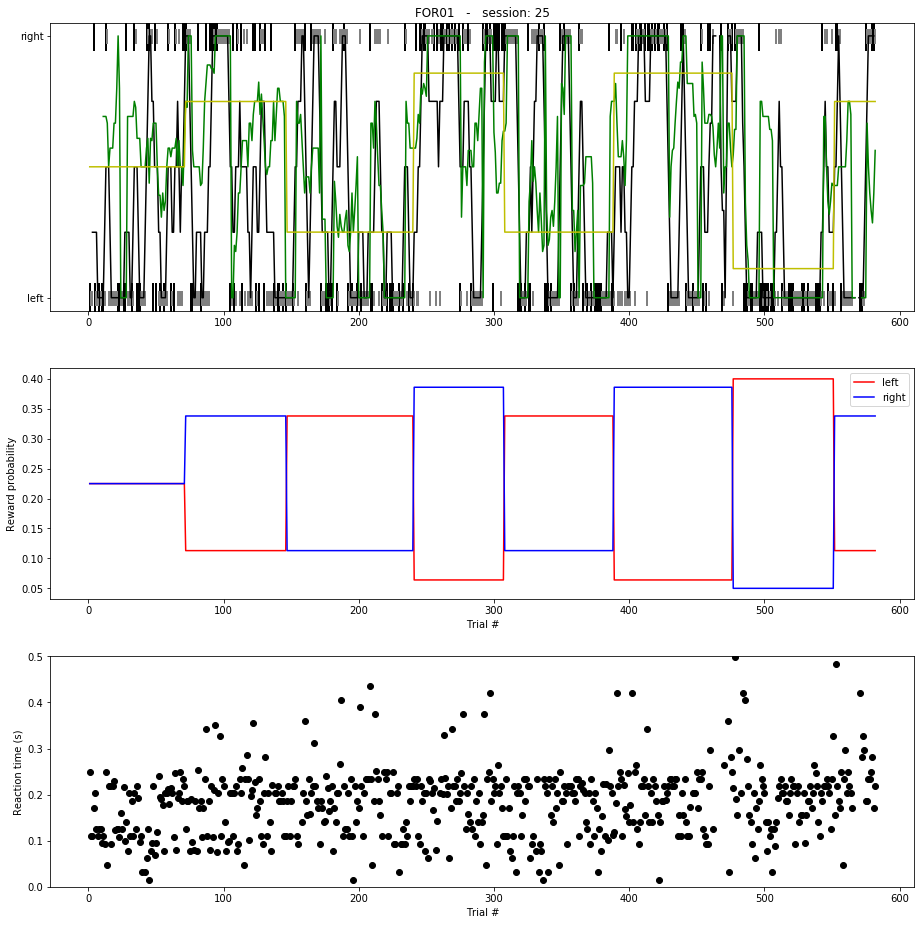

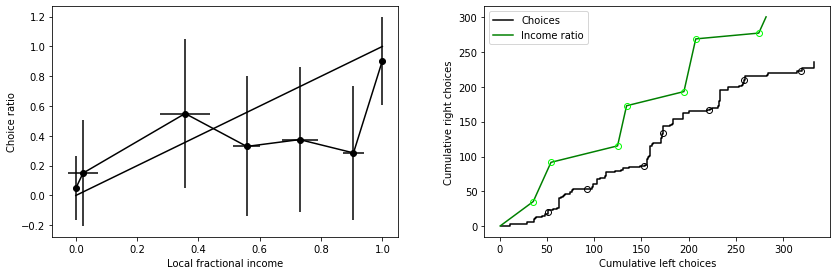

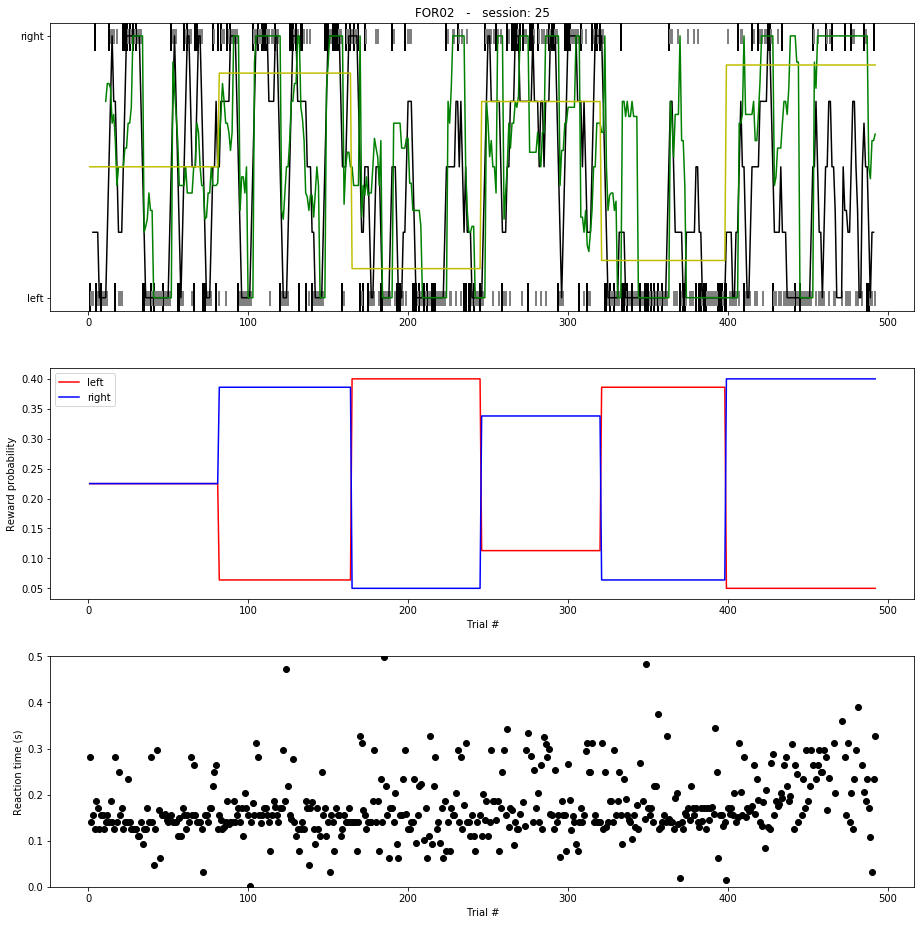

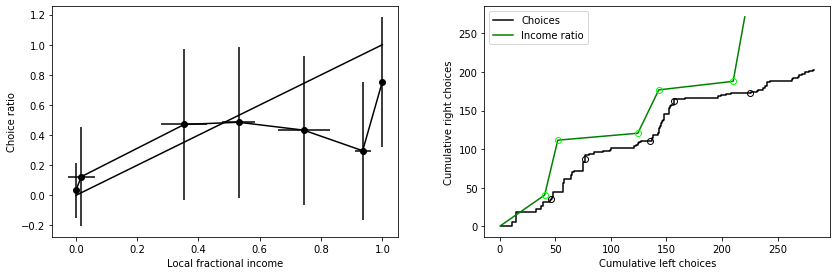

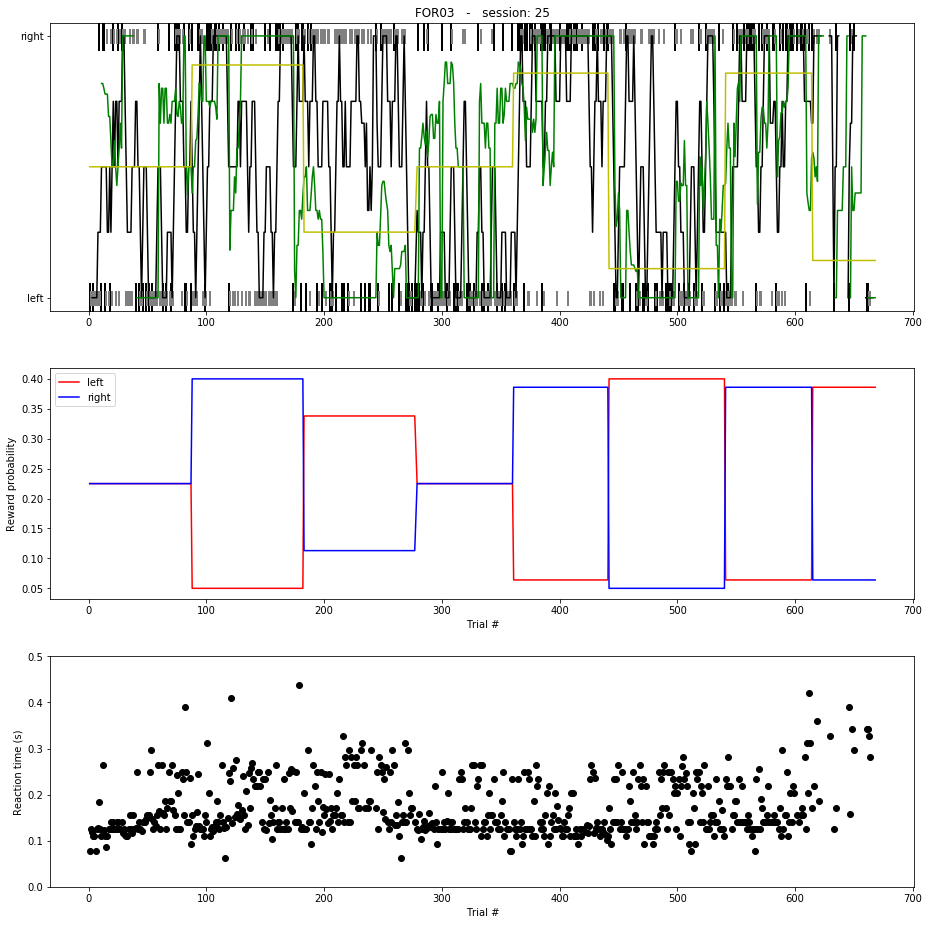

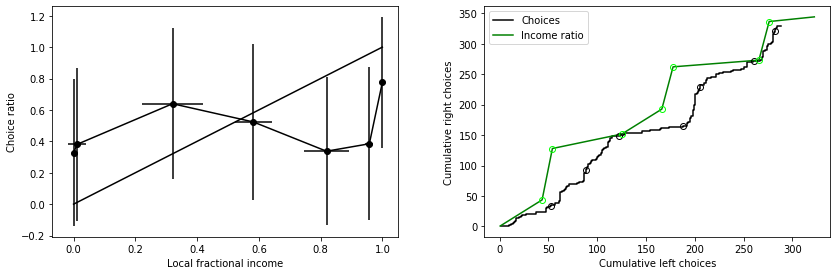

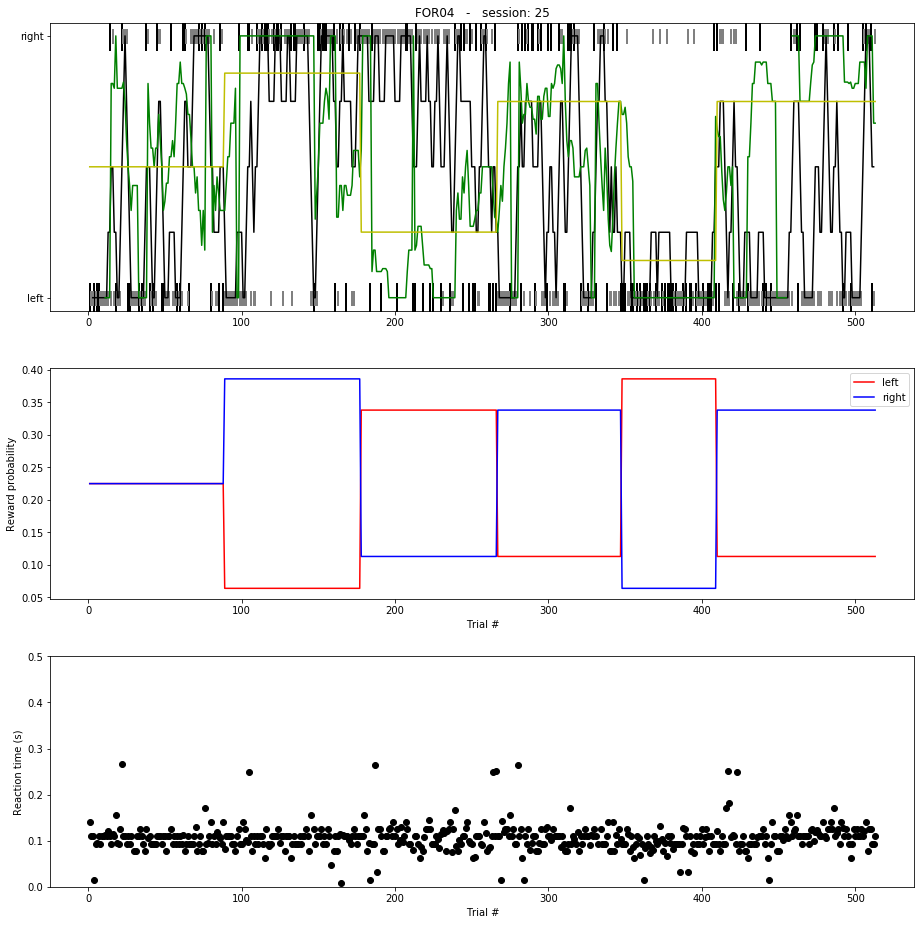

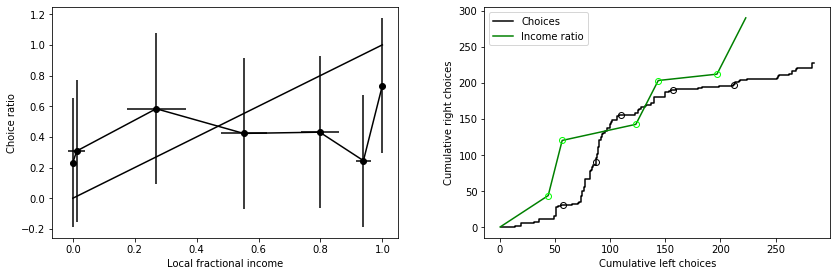

In [8]:
session = 25
plot_one_session(wr_name = 'FOR01',session = session,local_filter = template)
plot_one_session(wr_name = 'FOR02',session = session,local_filter = template)
plot_one_session(wr_name = 'FOR03',session = session,local_filter = template)
plot_one_session(wr_name = 'FOR04',session = session,local_filter = template)

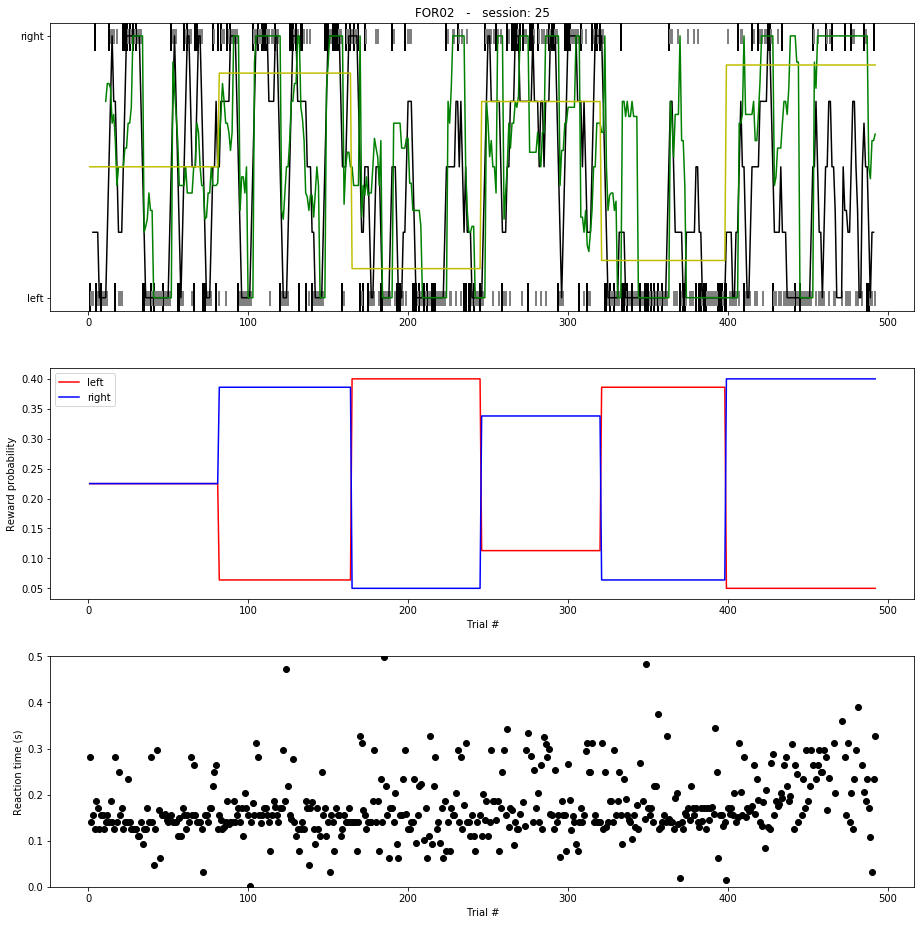

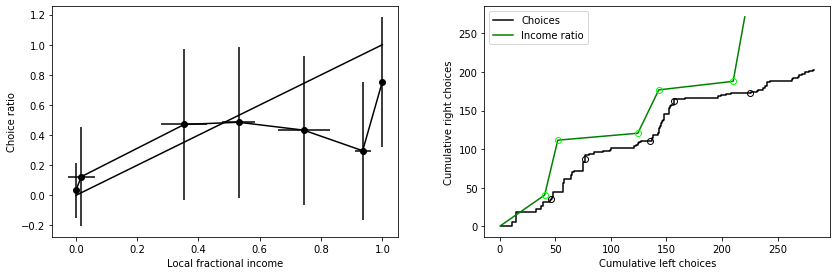

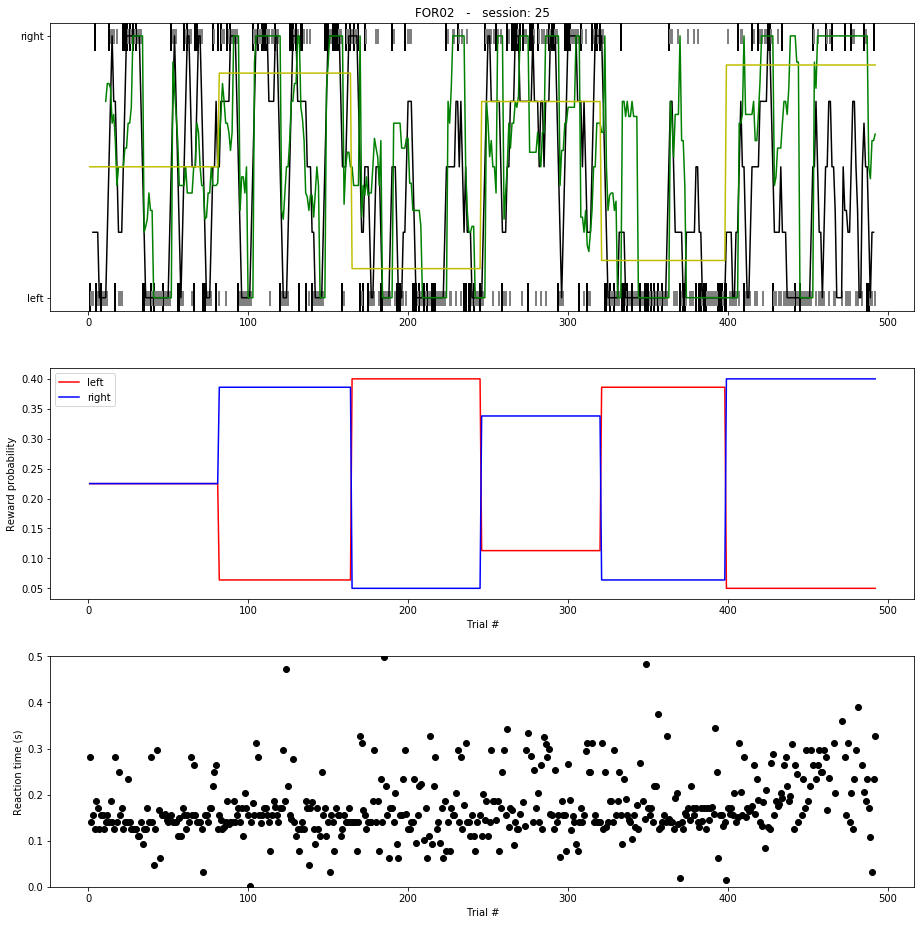

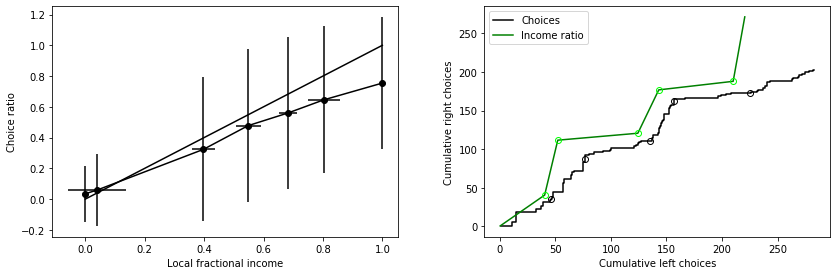

In [13]:
session = 25
plot_one_session(wr_name = 'FOR02',session = session,local_filter = template)
plot_one_session(wr_name = 'FOR02',session = session)


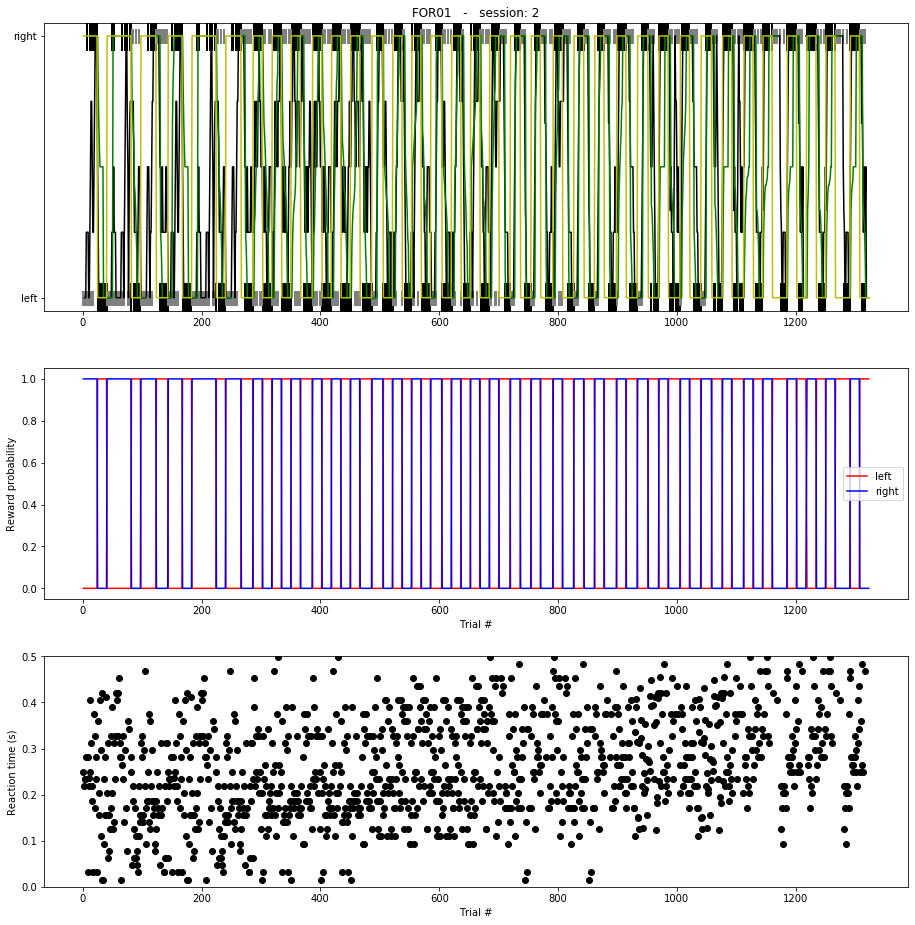

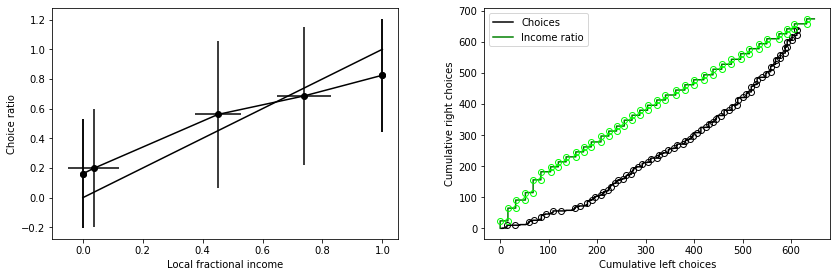

In [8]:
session = 2
plot_one_session(wr_name = 'FOR01',session = session)